In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [2]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [3]:
# Load data
results_files = ["20210913-122557.csv", "20210910-113516.csv"]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Benchmark                 300 non-null    object 
 1   Mode                      300 non-null    object 
 2   Threads                   300 non-null    int64  
 3   Samples                   300 non-null    int64  
 4   Score                     300 non-null    float64
 5   Score Error (99.9%)       300 non-null    float64
 6   Unit                      300 non-null    object 
 7   Param: metaborgVersion    300 non-null    object 
 8   Param: optimisationLevel  300 non-null    int64  
 9   Param: problemSize        300 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 23.6+ KB


In [4]:
for col in ["Score", "Score Error (99.9%)"]:
    if df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [5]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [6]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize
0,benchmark.stratego2.execution.Quicksort.run,ss,1,15,0.832374,0.052615,s/op,2.6.0-SNAPSHOT,2,10
1,benchmark.stratego2.execution.Quicksort.run,ss,1,15,1.721658,0.043221,s/op,2.6.0-SNAPSHOT,2,12
2,benchmark.stratego2.execution.Quicksort.run,ss,1,15,3.912453,0.377634,s/op,2.6.0-SNAPSHOT,2,14
3,benchmark.stratego2.execution.Quicksort.run,ss,1,15,10.456617,0.875447,s/op,2.6.0-SNAPSHOT,2,16
4,benchmark.stratego2.execution.Quicksort.run,ss,1,15,39.333356,1.651302,s/op,2.6.0-SNAPSHOT,2,18
...,...,...,...,...,...,...,...,...,...,...
295,benchmark.stratego2.execution.Hanoi.run,ss,1,15,1.693099,0.014060,s/op,2.6.0-SNAPSHOT,4,10
296,benchmark.stratego2.execution.Hanoi.run,ss,1,15,3.393445,0.297794,s/op,2.6.0-SNAPSHOT,4,11
297,benchmark.stratego2.execution.Quicksort.run,ss,1,15,0.833775,0.006774,s/op,2.6.0-SNAPSHOT,2,10
298,benchmark.stratego2.execution.Quicksort.run,ss,1,15,0.846598,0.050855,s/op,2.6.0-SNAPSHOT,3,10


In [7]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])

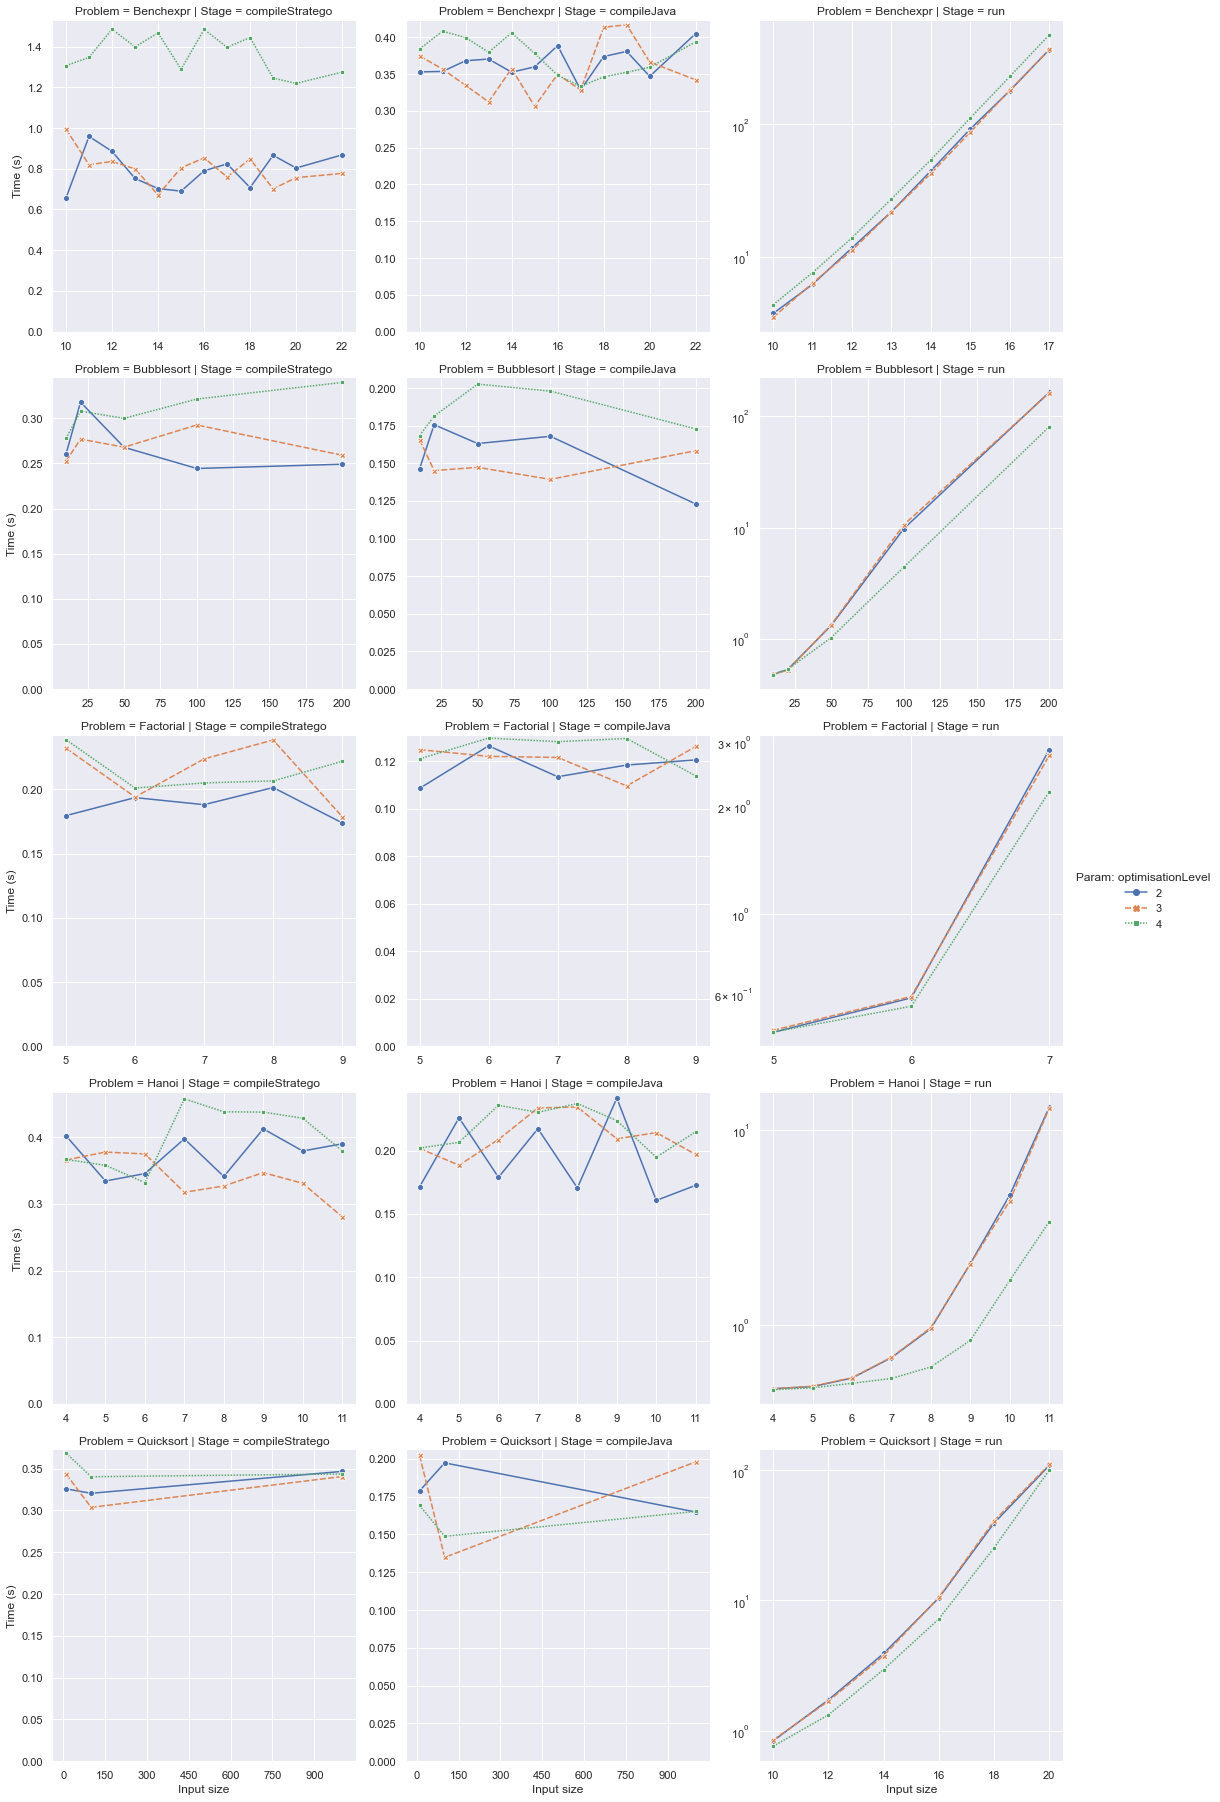

In [19]:
df_scaledproblem = df[df["Param: problemSize"] != -1]

g = sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "compileJava", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: optimisationLevel",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
)

# TODO Include strj runtime -> with and without fusion


## Global settings
g.set_ylabels("Time (s)")
g.set_xlabels("Input size")
for axs in g.axes:
    for ax in axs:
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Bubblesort", "Factorial", "Hanoi", "Quicksort"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava"},
        "settings": {"ylim": (0, None)}
    }
]

for (row_val, col_val), ax in g.axes_dict.items():
    for config in configs:
        if "problems" not in config or row_val in config["problems"]:
            if "stages" not in config or col_val in config["stages"]:
                ax.set(**config["settings"])


# Save figure to file
plt.savefig(f"example-plots/{'_'.join(results_files)}-scaled.png", transparent=False)

In [ ]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]

print(df_unscaledproblem.to_latex(
    columns=["Problem", "Stage", "Samples", "Score", "Score Error (99.9%)", "Param: optimisationLevel"]
))

df_unscaledproblem

In [17]:
np.sort(np.unique(df_scaledproblem["Problem"].values))

array(['Benchexpr', 'Bubblesort', 'Factorial', 'Hanoi', 'Quicksort'],
      dtype=object)

In [18]:
np.unique(df_scaledproblem["Problem"].values)

array(['Benchexpr', 'Bubblesort', 'Factorial', 'Hanoi', 'Quicksort'],
      dtype=object)